In [ ]:
Z_DIM = 5

In [ ]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete
import itertools

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 14.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Colored MNIST dataset

In [ ]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, split='Tr'):
        self.split = split
        self.mnist_sz = 28

        # get mnist
        if split == 'Test':
            mnist = datasets.MNIST(root='data', download=True, train=False)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        ims = mnist.data
        labels = mnist.targets

        self.T = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        if self.split == 'CF':
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.split == 'Tr':
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                forbidden_bg_i = [digit, (digit + 1) % NUM_COLORS, (digit + 2) % NUM_COLORS, fg_i]
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in forbidden_bg_i])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                forbidden_bg_i = [digit, (digit + 2) % NUM_COLORS, fg_i]
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in forbidden_bg_i])
        elif self.split == 'TrCF':
            fg_i = int(digit)
            bg_i = int((digit + 2) % NUM_COLORS)
        elif self.split == 'CF':
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        elif self.split == 'Test':
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        else:
            assert False
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            'img': self.T(ims),
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [ ]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_Tr = DoubleColoredMNIST(split='Tr')
dataset_TrCF = DoubleColoredMNIST(split='TrCF')
dataset_CF = DoubleColoredMNIST(split='CF')
print(len(dataset_Tr), len(dataset_TrCF), len(dataset_CF))
print(LABEL_SIZES)

60000 60000 29492
[10, 10, 10]


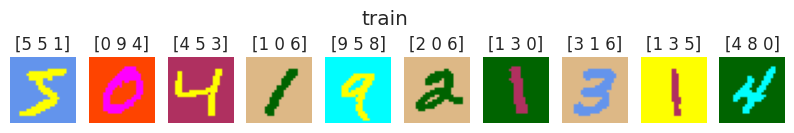

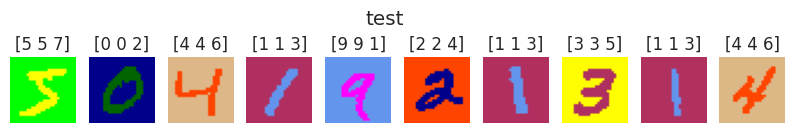

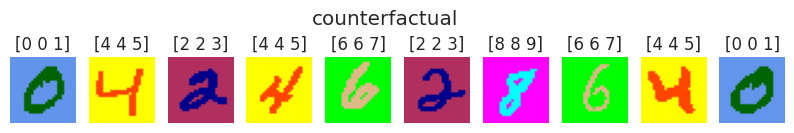

In [ ]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_Tr, dataset_TrCF, dataset_CF]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [ ]:
BATCH_SIZE = 256
Tr_loader = DataLoader(dataset_Tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
TrCF_loader = DataLoader(dataset_TrCF, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
CF_loader = DataLoader(dataset_CF, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. Load Classifier

In [ ]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
simple_cnn = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=30)
).to(device)
simple_cnn.load_state_dict(torch.load('/content/drive/MyDrive/thesis/classifier.pth', map_location=device))

<All keys matched successfully>

In [ ]:
simple_cnn.train(False)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Dropout(p=0.4, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Dropout(p=0.4, inplace=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=1024, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=30, bias=True)
)

### 3. CVAE

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3136 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3136 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=64*7*7)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.first_layer(x).view((-1, 64, 7, 7))
        return self.upsampling_layers(x)

In [ ]:
DAMPING_FACTOR = 0.1

def mse(A, B):
    return ((A - B)**2).mean(axis=1)

class CVAE(nn.Module):
    def __init__(self, regressor, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=True):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        self.regressor_ = regressor
        self.criterion = nn.CrossEntropyLoss()
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def get_one_hot(self, labels):
        new_ys = []
        for i, label_length in enumerate(LABEL_SIZES):
            new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
            new_ys.append(new_y)
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)

    def model(self, x, labels, x_TrCF, labels_TrCF):
        if self.use_cuda:
            x = x.cuda()
            x_TrCF = x_TrCF.cuda()
            labels = labels.cuda()
            labels_TrCF = labels_TrCF.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, self.get_one_hot(labels)], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3),
                        obs=x.squeeze())

            # loss-2
            loc_img_TrCF = self.decoder_(torch.cat([z, self.get_one_hot(labels_TrCF)], dim=1))
            logits = self.regressor_(loc_img_TrCF)

            xe_loss =  self.criterion(logits[:, :10],   labels_TrCF[:, 0].long().to(device))
            xe_loss += self.criterion(logits[:, 10:20], labels_TrCF[:, 1].long().to(device))
            xe_loss += self.criterion(logits[:, 20:],   labels_TrCF[:, 2].long().to(device))
            xe_loss *= DAMPING_FACTOR
            pyro.factor("classifier_ce_loss", -xe_loss)

    def guide(self, x, labels, x_TrCF, labels_TrCF):
        if self.use_cuda:
            x = x.cuda()
            x_TrCF = x_TrCF.cuda()
            labels = labels.cuda()
            labels_TrCF = labels_TrCF.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, self.get_one_hot(labels))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        z_loc, z_scale = self.encoder_(x, y_one_hot)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        y_one_hot = self.get_one_hot(labels)
        loc_img = self.decoder_(torch.cat([z, y_one_hot], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 4. Train

In [ ]:
def run_epoch(svi, Tr_loader, TrCF_loader):
    epoch_loss = 0.
    for Tr_batch, TrCF_batch in zip(Tr_loader, itertools.cycle(TrCF_loader)):
        if len(TrCF_batch) != len(Tr_batch):
            k = min(len(TrCF_batch), len(Tr_batch))
            epoch_loss += svi.step(Tr_batch['img'][:k].to(device), Tr_batch['label'][:k].to(device),
                                   TrCF_batch['img'][:k].to(device), TrCF_batch['label'][:k].to(device))
        else:
            epoch_loss += svi.step(Tr_batch['img'].to(device), Tr_batch['label'].to(device),
                                   TrCF_batch['img'].to(device), TrCF_batch['label'].to(device))
    return epoch_loss / len(Tr_loader.dataset)

def show_reconstructions(vae, loader, cols=5, rows=1, title=''):
    for k, batch in enumerate(loader):
        if k >= rows:
            return
        x = batch['img']
        l = batch['label']
        plt.figure(figsize=(1.5 * cols, 3))
        for i in range(cols):
            plt.subplot(2, cols, i+1)
            plt.imshow(normalize(x[i].permute(1, 2, 0)))
            plt.axis('off')
            plt.subplot(2, cols, i+cols+1)
            rec_img = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy().transpose((1, 2, 0))
            plt.imshow(normalize(rec_img))
            plt.axis('off')
        plt.suptitle(title, y=.9)
        plt.tight_layout()

def callback(train_elbo, test_elbo, test_epoch_num, epoch, vae):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    if test_elbo is not None:
        plt.plot(test_epoch_num, test_elbo, lw=2, color='#FF3300', label='test')
    plt.legend()
    plt.xlabel('epoch')
    plt.title(f'Epoch {epoch}. ELBO {train_elbo[-1]}')
    plt.show()
    vae.train(False);
    show_reconstructions(vae, CF_loader, 4, 1, title='counterfactual')
    show_reconstructions(vae, TrCF_loader, 4, 1, title='test')
    vae.train(True);
    plt.show()


LEARNING_RATE = 5.0e-4
USE_CUDA = torch.cuda.is_available()
pyro.clear_param_store()
adam_args = {"lr": LEARNING_RATE}

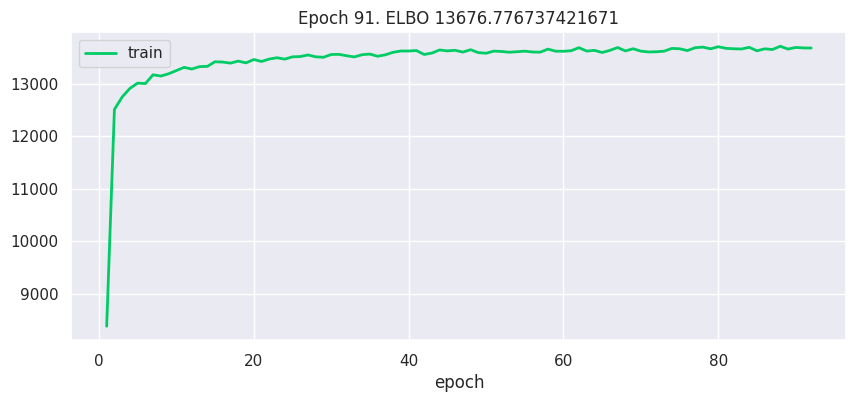

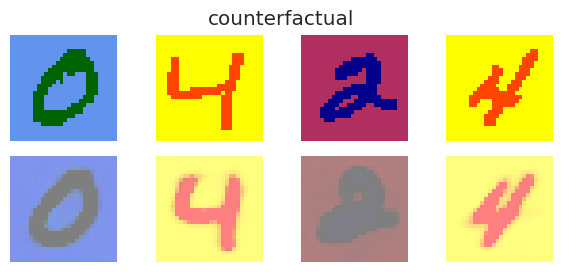

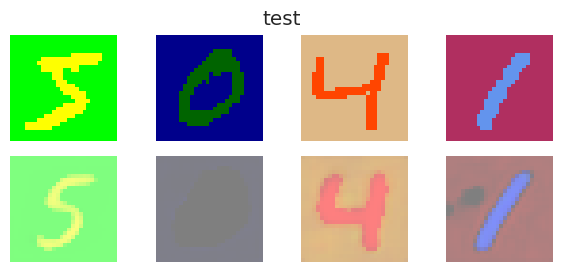

In [ ]:
# vae = CVAE(regressor=simple_cnn, z_dim=Z_DIM, p=0.1, use_cuda=USE_CUDA)
# optimizer = Adam(adam_args)
# svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
# last_params = {}

# train_elbo = []
# test_elbo = []
# test_epoch_num = []

for epoch in range(16, 100):
    total_epoch_loss_train = run_epoch(svi, Tr_loader, TrCF_loader)
    train_elbo.append(-total_epoch_loss_train)
    test_epoch_num.append(epoch+1)
    if epoch % 10 == 0 :
        torch.save(vae.state_dict(), '/content/drive/MyDrive/thesis/mnist_anm_06_11_zdim5.pth')
        callback(train_elbo, None, test_epoch_num, epoch+1, vae)